# Milestone 2: Data Exploration & Initial Preprocessing

## Data exploration

We have 5 rice varieties in our image data, Arborio, Basmati, Ipsala, Jasmine, and Karacadag. The total number of the images is 75,000. Each of the varieties has 15,000 images from different angles and sizes. The image sizes are all 250x250 pixels, but the sizes of each rice are different. Every image is in a dark background with exactly one rice in the middle of the image. We will look at this image and use OpenCV to get the feature from those image datasets. The features we will extract are displayed in the next cell.

## The feature and explanations extract from the image datasets

In [ ]:
import pandas as pd
from IPython.display import display, HTML

In [ ]:
data = {
    "Variable Name": ["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent"],
    "Role": ["Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature"],
    "Type": ["Integer", "Continuous", "Continuous", "Continuous", "Continuous", "Integer", "Continuous"],
    "Description": [
        "Returns the number of pixels within the boundaries of the rice grain",
        "Calculates the circumference by calculating the distance between pixels around the boundaries of the rice grain",
        "The longest line that can be drawn on the rice grain, i.e. the main axis distance",
        "The shortest line that can be drawn on the rice grain, i.e. the small axis distance",
        "It measures how round the ellipse, which has the same moments as the rice grain",
        "Returns the pixel count of the smallest convex shell of the region formed by the rice grain",
        "Returns the ratio of the region formed by the rice grain to the bounding box pixels"
    ]
}
df = pd.DataFrame(data)
display(HTML(df.to_html(index=False)))

Variable Name,Role,Type,Description
Area,Feature,Integer,Returns the number of pixels within the boundaries of the rice grain
Perimeter,Feature,Continuous,Calculates the circumference by calculating the distance between pixels around the boundaries of the rice grain
Major_Axis_Length,Feature,Continuous,"The longest line that can be drawn on the rice grain, i.e. the main axis distance"
Minor_Axis_Length,Feature,Continuous,"The shortest line that can be drawn on the rice grain, i.e. the small axis distance"
Eccentricity,Feature,Continuous,"It measures how round the ellipse, which has the same moments as the rice grain"
Convex_Area,Feature,Integer,Returns the pixel count of the smallest convex shell of the region formed by the rice grain
Extent,Feature,Continuous,Returns the ratio of the region formed by the rice grain to the bounding box pixels


## Retrieve the data

In [ ]:
!git lfs install
!git clone https://huggingface.co/datasets/nateraw/rice-image-dataset
!unzip /content/rice-image-dataset/rice-image-dataset.zip -d /content/rice-image-dataset/

Git LFS initialized.
fatal: destination path 'rice-image-dataset' already exists and is not an empty directory.
Archive:  /content/rice-image-dataset/rice-image-dataset.zip
replace /content/rice-image-dataset/Rice_Image_Dataset/Arborio/Arborio (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## install opencv and pandas (colab notebook already install)

In [ ]:
!pip install opencv-python-headless pandas

## Getting the features from image

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Extract the features from the given image
# param image_path: The image path
# return: The list of data for each feature
def extract_features(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Check if the image is loaded successfully
    if image is None:
        print(f"Failed to load image: {image_path}")
        return []

    # Binary thresholding
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Show the original image and contours
    #image_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    #cv2.drawContours(image_contours, contours, -1, (0, 255, 0), 2)
    #plt.imshow(image_contours)
    #plt.title("Contours")
    #plt.show()

    # Initialize feature list
    features_list = []

    for contour in contours:
        # Calculate features
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        x, y, w, h = cv2.boundingRect(contour)
        major_axis_length = max(w, h)
        minor_axis_length = min(w, h)
        eccentricity = 0  # Default value for eccentricity
        if len(contour) >= 5:  # fitEllipse needs at least 5 points
            (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
            if MA < ma:
              MA, ma = ma, MA
            if MA > 0 and ma > 0:
              eccentricity = np.sqrt(1 - (ma/MA)**2)
        hull = cv2.convexHull(contour)
        convex_area = cv2.contourArea(hull)
        extent = area / (w * h) if w * h > 0 else 0

        # Append features to list
        features = [area, perimeter, major_axis_length, minor_axis_length, eccentricity, convex_area, extent]
        features_list.append(features)

    return features_list

In [ ]:
# Define the main directory path
main_directory_path = '/content/rice-image-dataset/Rice_Image_Dataset'

# Get all class subdirectories
classes = os.listdir(main_directory_path)
classes.remove('Rice_Citation_Request.txt')
all_features = []

# Iterate through each class subdirectory
for class_name in classes:
    class_path = os.path.join(main_directory_path, class_name)
    if os.path.isdir(class_path):
        # Get all image files in the class directory
        for filename in os.listdir(class_path):
            if filename.endswith(".png") or filename.endswith(".jpg"):
                image_path = os.path.join(class_path, filename)
                features = extract_features(image_path)

                # add class
                features[0].append(class_name)
                if features:
                    all_features.extend(features)

# Initialize DataFrame
columns = ["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent", "Class"]
df = pd.DataFrame(all_features, columns=columns)

# Drop rows with NaN values
df = df.dropna()

# Add additional columns
df['Variable Name'] = ["Feature"] * len(df)
df['Role'] = ["Feature"] * len(df)
df['Type'] = ["Continuous"] * len(df)
df['Description'] = [""] * len(df)
df['Units'] = [""] * len(df)
df['Missing Values'] = ["no"] * len(df)

# Rearrange column order
df = df[["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent", "Class"]]


In [ ]:
# Display the DataFrame
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width', 1000)
print(df)

         Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  Convex_Area    Extent      Class
0      6431.0  320.107645                118                 71      0.813997       6530.0  0.767606  Karacadag
1      6212.0  316.735062                100                 90      0.751525       6390.5  0.690222  Karacadag
2      6319.5  323.663994                104                 89      0.796115       6515.0  0.682746  Karacadag
3      6832.5  331.806130                107                 93      0.777818       6964.0  0.686614  Karacadag
4      6365.5  315.663994                111                 79      0.764807       6470.0  0.725909  Karacadag
...       ...         ...                ...                ...           ...          ...       ...        ...
74995  6746.5  453.428494                171                116      0.980292       6948.5  0.340114    Basmati
74996  7864.0  473.872145                178                116      0.974749       8309.5  0.380860    

In [ ]:
# Count the number of classes and images
num_classes = len(classes)
num_images = len(all_features)

print(f"Number of classes: {num_classes}")
print(f"Number of images: {num_images}")

Number of classes: 5
Number of images: 75000


## Example image for each rice varieties

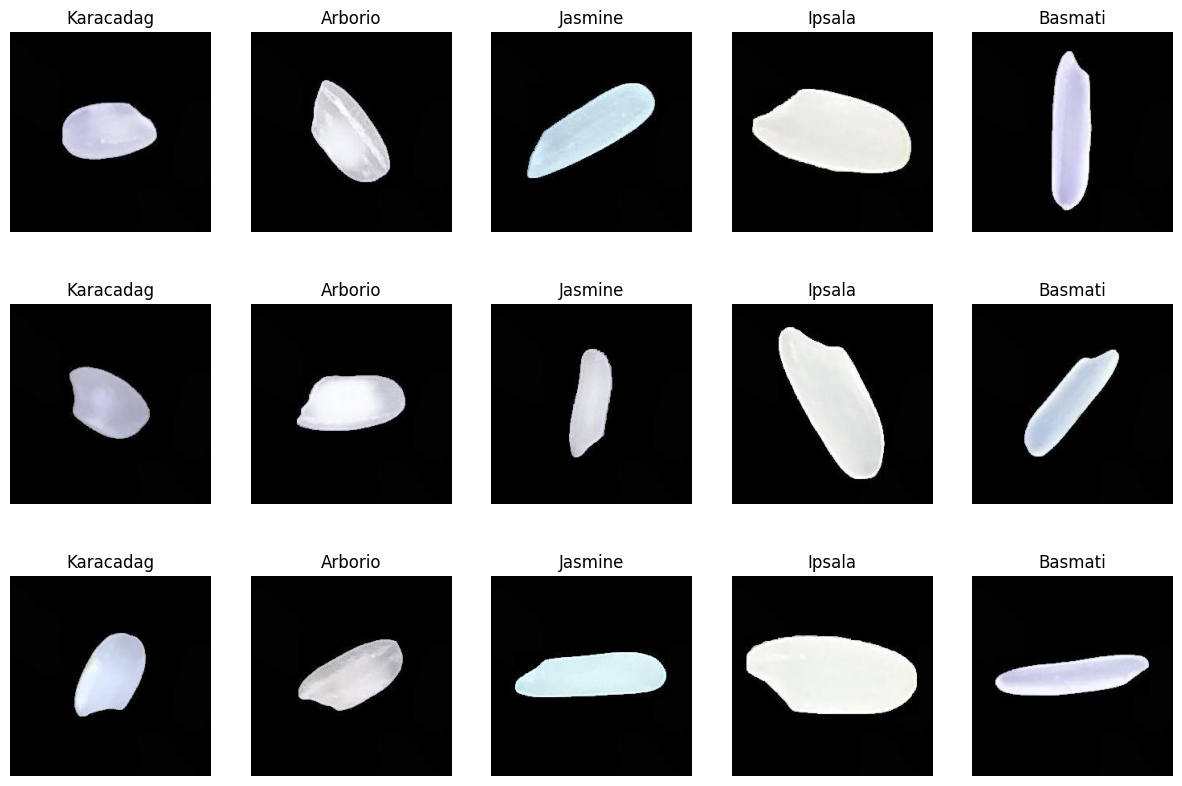

In [ ]:
# Plot three images for each variety
fig, axs = plt.subplots(3, len(classes), figsize=(15, 10))

for i, class_name in enumerate(classes):
    class_path = os.path.join(main_directory_path, class_name)
    if os.path.isdir(class_path):
        image_paths = os.listdir(class_path)[:3]
        for j, image_path in enumerate(image_paths):
            image_path = os.path.join(class_path, image_path)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Plot the image
            axs[j, i].imshow(image, cmap='gray')
            axs[j, i].set_title(class_name)
            axs[j, i].axis('off')

plt.show()

## Data Exploration

               Area     Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity   Convex_Area        Extent
count  75000.000000  75000.000000       75000.000000       75000.000000  75000.000000  75000.000000  75000.000000
mean    8206.674293    398.497899         148.066867          91.670333      0.889055   8414.327127      0.619275
std     3092.094279     74.269905          33.308083          24.762705      0.072231   3162.466775      0.121558
min     3808.500000    277.521860          86.000000          37.000000      0.610742   3907.000000      0.271136
25%     6118.500000    333.379724         119.000000          75.000000      0.848184   6246.500000      0.548034
50%     7179.000000    370.232535         141.000000          88.000000      0.888345   7366.500000      0.642242
75%     8705.625000    468.835567         179.000000         105.000000      0.955154   8959.500000      0.711852
max    20740.000000    625.587875         242.000000         179.000000      0.989206  2

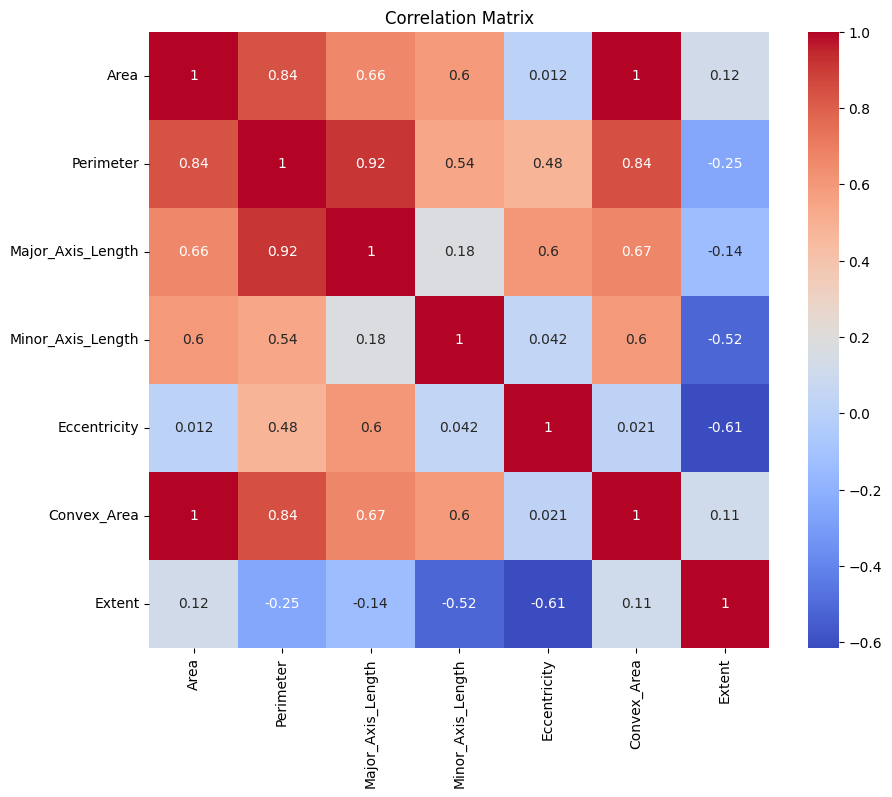

In [ ]:
import seaborn as sns

# View descriptive statistics
print(df.describe())

# Check the number of missing values ​​in each column
print(df.isnull().sum())

# Plotting a heatmap of the correlation matrix
corr = df.drop(columns=['Class']).corr()
# corr = df
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

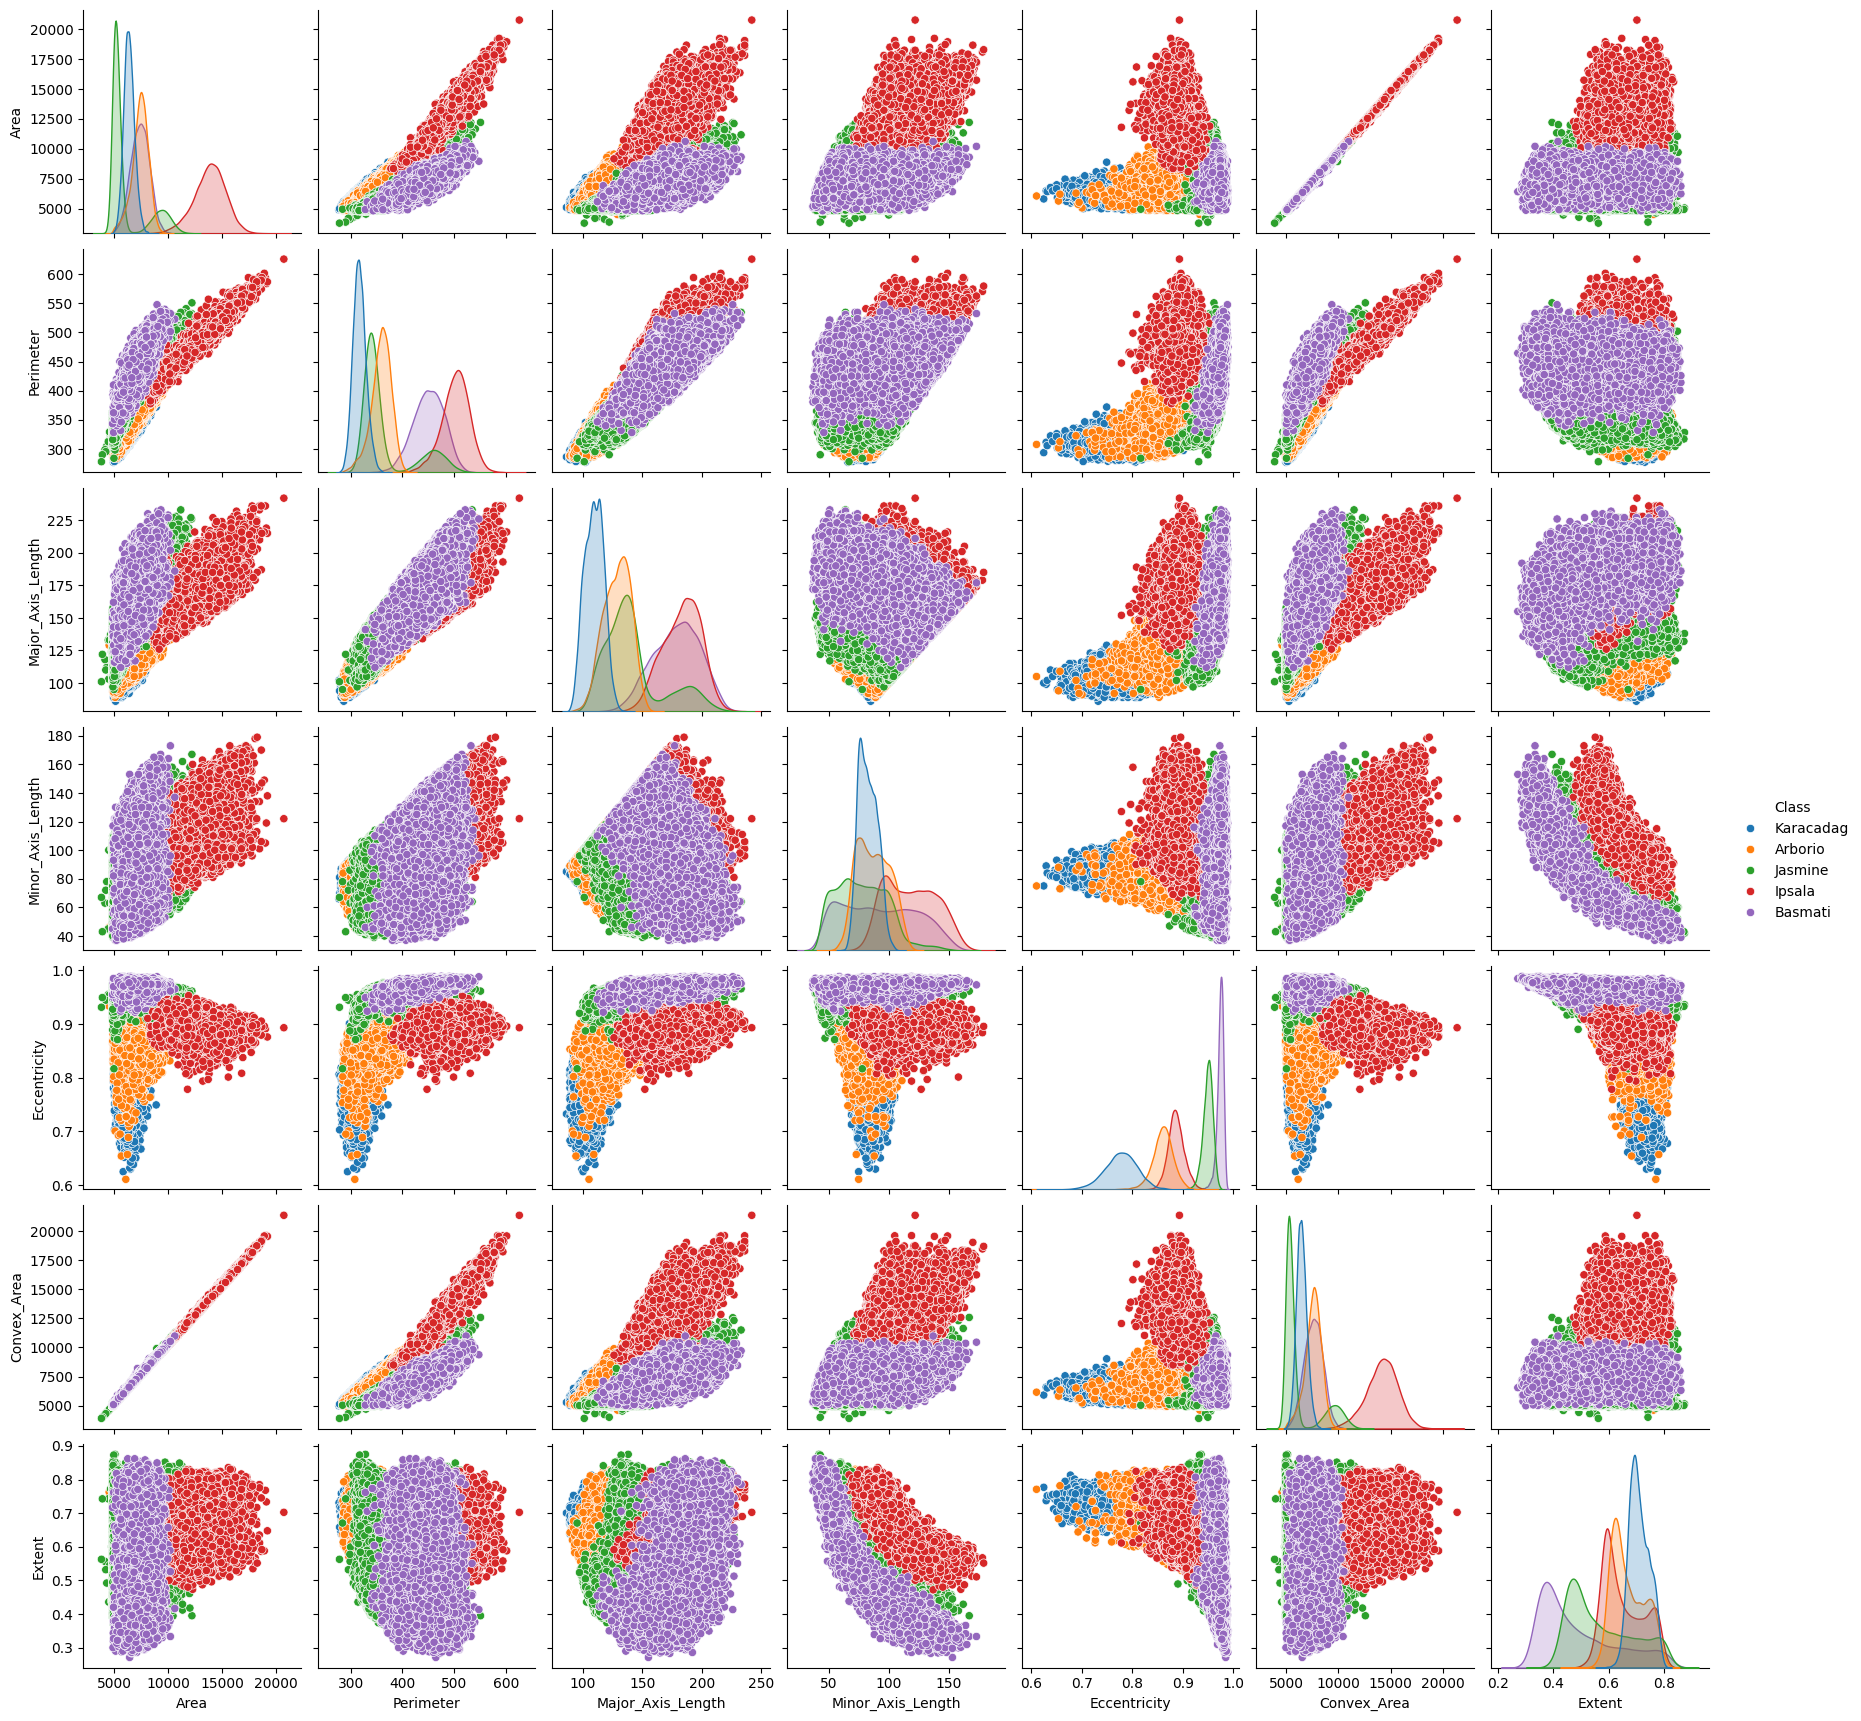

In [ ]:
#show pairplot
sns.pairplot(df, diag_kind='kde', hue='Class')
plt.show()

In [ ]:
# Class encoding
new_label = { label:idx for idx, label in enumerate(df['Class'].unique()) } # {'Basmati': 0, 'Jasmine': 1, 'Arborio': 2, 'Ipsala': 3, 'Karacadag': 4}
df['Class'] = df['Class'].map(new_label)
df['Class']

0        0
1        0
2        0
3        0
4        0
        ..
74995    4
74996    4
74997    4
74998    4
74999    4
Name: Class, Length: 75000, dtype: int64

               Area     Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity   Convex_Area        Extent         Class
count  75000.000000  75000.000000       75000.000000       75000.000000  75000.000000  75000.000000  75000.000000  75000.000000
mean    8206.674293    398.497899         148.066867          91.670333      0.889055   8414.327127      0.619275      2.000000
std     3092.094279     74.269905          33.308083          24.762705      0.072231   3162.466775      0.121558      1.414223
min     3808.500000    277.521860          86.000000          37.000000      0.610742   3907.000000      0.271136      0.000000
25%     6118.500000    333.379724         119.000000          75.000000      0.848184   6246.500000      0.548034      1.000000
50%     7179.000000    370.232535         141.000000          88.000000      0.888345   7366.500000      0.642242      2.000000
75%     8705.625000    468.835567         179.000000         105.000000      0.955154   8959.500000     

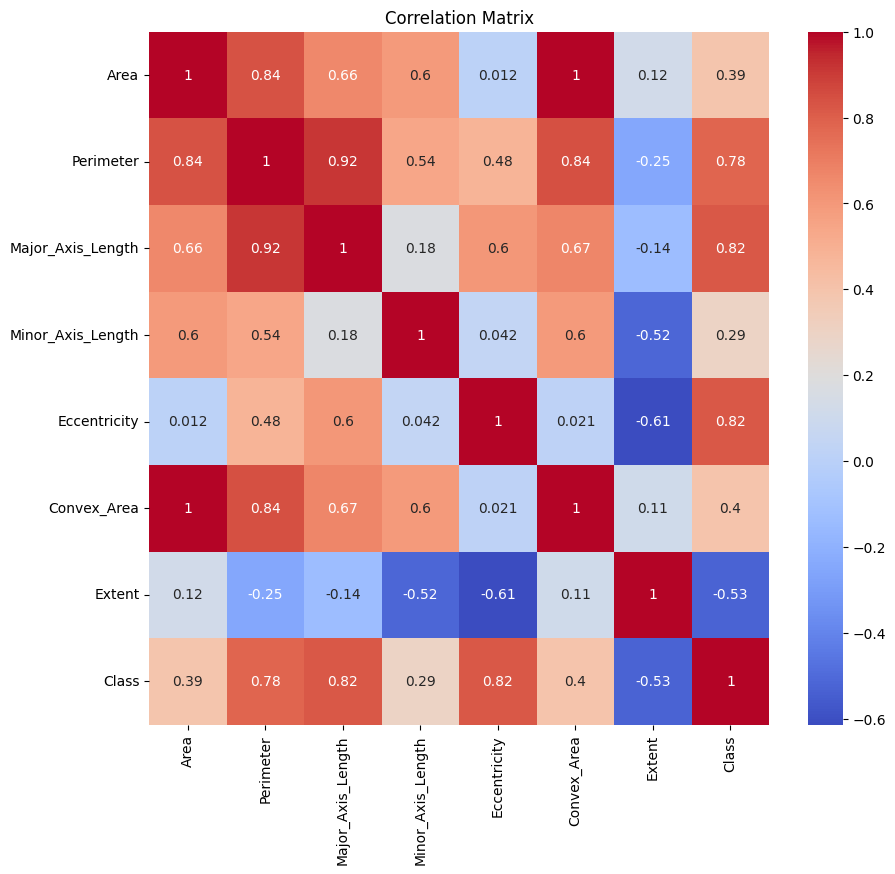

In [ ]:
# View descriptive statistics
print(df.describe())

# Check the number of missing values ​​in each column
print(df.isnull().sum())

# Plotting a heatmap of the correlation matrix
corr = df.corr()
plt.figure(figsize=(10, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Preprocess the data
The process of preprocess the data will be in [README](https://github.com/Astraeven0502/CSE151A_Group_Project-Rice_Classification/blob/main/README.md)


# Milestone 3: Pre-Processing

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

## Normalize and Standardize data

In [ ]:
def preprocess_rice_data(df):
    # # Extract features that are highly correlated with `Class`
    features = df[['Perimeter','Area','Convex_Area']]
    labels = df['Class']

    # Normalize features
    # normalizer = MinMaxScaler()
    # normalized_features = normalizer.fit_transform(features)

    # Standardize features
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(features)

    # Combine normalized and standardized features with original class labels
    # processed_data = pd.DataFrame(normalized_features, columns=features.columns)
    processed_data = pd.DataFrame(standardized_features, columns=features.columns)
    processed_data['Class'] = labels.values

    return processed_data

In [ ]:
df_pre = preprocess_rice_data(df)
df_pre

,Perimeter,Area,Convex_Area,Class
0,-0.976051,-0.453150,-0.458293,0
1,-1.002980,-0.561492,-0.565805,0
2,-1.291312,-0.811971,-0.831738,0
3,-1.148780,-0.701204,-0.719641,0
4,-1.094361,-0.581381,-0.595845,0
...,...,...,...,...
74995,0.615329,-0.226442,-0.211490,4
74996,1.164175,-0.405771,-0.374813,4
74997,0.572858,-0.166773,-0.170857,4
74998,0.875843,-0.238408,-0.222400,4


## Model 1 - Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, log_loss

In [ ]:
# Make a list for every possible pair
df_list = []
for i in range(5):
  for j in range(i+1, 5):
    df_list.append([i, j])
df_list = df_list[:10]
print(df_list)

[[0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]


In [ ]:
def model_train(df_list):
    df_0_1 = df_pre[(df_pre['Class']==df_list[0]) | (df_pre['Class']==df_list[1])]
    X = df_0_1.drop('Class', axis=1)
    y = df_0_1['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    cost = log_loss(y_test, y_pred_proba)
    return [model, cost]

In [ ]:
model_list = []

In [ ]:
for pair in df_list:
  model_t = model_train(pair)
  model_list.append(model_t)
  print(model_t[1])

0.12458789424893596
0.006605916650614512
0.0006551184601912476
0.0024893530055289017
0.023599622965840884
0.006146419230841097
0.0048432497840150655
0.00876533394048509
0.11432061769786739
0.0016449745570505775


In [ ]:
# The model for each pair
model_list

[[LogisticRegression(), 0.12458789424893596],
 [LogisticRegression(), 0.006605916650614512],
 [LogisticRegression(), 0.0006551184601912476],
 [LogisticRegression(), 0.0024893530055289017],
 [LogisticRegression(), 0.023599622965840884],
 [LogisticRegression(), 0.006146419230841097],
 [LogisticRegression(), 0.0048432497840150655],
 [LogisticRegression(), 0.00876533394048509],
 [LogisticRegression(), 0.11432061769786739],
 [LogisticRegression(), 0.0016449745570505775]]

## Split the data

In [ ]:
X = df_pre.drop('Class', axis=1)
y = df_pre['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)
y_test.unique()

array([1, 0, 4, 2, 3])

In [ ]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

       Perimeter      Area  Convex_Area
67421  -0.100367 -0.687459    -0.688811
72519   0.669980 -0.332196    -0.330228
51720   1.718297  2.464309     2.414483
67521  -0.895825 -0.846576    -0.855454
20707  -0.590598 -0.293710    -0.310306
...          ...       ...          ...
37194   1.064346  0.571405     0.571606
6265   -0.865861 -0.318775    -0.349833
54886   1.812384  2.199600     2.191239
860    -1.106869 -0.599331    -0.615450
15795  -0.593865 -0.272204    -0.293231

[7500 rows x 3 columns]
       Perimeter      Area  Convex_Area
26837  -0.375166 -0.120041    -0.143347
2592   -1.341903 -0.967368    -0.982413
18359  -0.650429 -0.428086    -0.436158
73292   0.908513 -0.172109    -0.175601
60127   1.164407 -0.131683    -0.100026
...          ...       ...          ...
28314  -0.710261 -0.446359    -0.470783
6791   -1.221679 -0.733383    -0.730393
68100   0.939038  0.032123     0.031676
13450  -1.053571 -0.545807    -0.574026
40612  -0.876783 -1.059216    -1.063995

[67500 rows x 

## Evaluate model

In [ ]:
# Train Error
train_output_matrix = model_list[0][0].predict(X_train)
for model in model_list[1:]:
  train_output_matrix = np.vstack((train_output_matrix, model[0].predict(X_train)))
train_yhat = []

for i in range(train_output_matrix.shape[1]):
  counts = np.bincount(train_output_matrix.T[i])
  train_yhat.append(np.argmax(counts))

train_accuracy = np.mean(train_yhat==y_train)
print(f"test_accuracy: {train_accuracy}")

test_accuracy: 0.9645333333333334


In [ ]:
# Test Error
test_output_matrix = model_list[0][0].predict(X_test)
for model in model_list[1:]:
  test_output_matrix = np.vstack((test_output_matrix, model[0].predict(X_test)))
test_output_matrix

yhat = []
for i in range(test_output_matrix.shape[1]):
  counts = np.bincount(test_output_matrix.T[i])
  yhat.append(np.argmax(counts))

test_accuracy = np.mean(yhat==y_test)
print(f"test_accuracy: {test_accuracy}")

test_accuracy: 0.9661037037037037


In [ ]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     13460
           1       0.96      0.95      0.95     13429
           2       0.95      0.96      0.96     13522
           3       1.00      0.99      1.00     13533
           4       0.97      0.96      0.96     13556

    accuracy                           0.97     67500
   macro avg       0.97      0.97      0.97     67500
weighted avg       0.97      0.97      0.97     67500



# Milestone 4 - Final

## Model 2 - Neural Network

In [ ]:
! pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam

In [ ]:
# Onehot
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder()
class_df = pd.DataFrame(ohe.fit_transform(df[['Class']]).toarray(),columns=ohe.get_feature_names_out())
class_df
# 'Arborio': 0, 'Jasmine': 1, 'Karacadag': 2, 'Basmati': 3, 'Ipsala': 4

,Class_0,Class_1,Class_2,Class_3,Class_4
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
74995,0.0,0.0,0.0,1.0,0.0
74996,0.0,0.0,0.0,1.0,0.0
74997,0.0,0.0,0.0,1.0,0.0
74998,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_pre.drop(columns=['Class']), class_df, test_size=0.2, random_state=42)

In [ ]:
import keras_tuner
from keras.optimizers import SGD, Adam, Adagrad
from keras_tuner import RandomSearch
from keras import layers

def buildHPmodel(hp):
    model = Sequential()
    model.add(layers.Flatten()) # The Flatten layer itself can be considered as an input layer
    for i in range(hp.Int("num_layers", min_value=4, max_value=10)):
      model.add(
          layers.Dense(
              units=hp.Int(f"units_layer_{i}", min_value=4, max_value=127, step=41),
              activation=hp.Choice(f"activation_layer_{i}", values=["softmax", "sigmoid", "relu"])
            )
          )
    if hp.Boolean("dropout"):
      model.add(layers.Dropout(rate=0.25))
    model.add(Dense(5, activation=hp.Choice("output_activation", values=["softmax", "sigmoid", "relu"])))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer_choice = hp.Choice('optimizer', ['SGD', 'Adam', 'Adagrad'])
    if optimizer_choice == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = Adagrad(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

buildHPmodel(keras_tuner.HyperParameters())

<Sequential name=sequential, built=False>

In [ ]:
tuner = RandomSearch(
    buildHPmodel,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    project_name="rice_classification_dataset"
)
tuner.search_space_summary()

Search space summary
Default search space size: 13
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_layer_0 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 127, 'step': 41, 'sampling': 'linear'}
activation_layer_0 (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid', 'relu'], 'ordered': False}
units_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 127, 'step': 41, 'sampling': 'linear'}
activation_layer_1 (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid', 'relu'], 'ordered': False}
units_layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 127, 'step': 41, 'sampling': 'linear'}
activation_layer_2 (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid', 'relu'], 'ordered': False}
units_layer_3 (Int)
{'default': None, 'conditions': [], 'min_value': 4,

In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Optimal hyperparameters:")
print(best_hps.values)

Trial 5 Complete [00h 01m 34s]
val_accuracy: 0.19966666400432587

Best val_accuracy So Far: 0.9735333323478699
Total elapsed time: 00h 05m 37s
Optimal hyperparameters:
{'num_layers': 6, 'units_layer_0': 45, 'activation_layer_0': 'sigmoid', 'units_layer_1': 4, 'activation_layer_1': 'sigmoid', 'units_layer_2': 45, 'activation_layer_2': 'relu', 'units_layer_3': 45, 'activation_layer_3': 'relu', 'dropout': False, 'output_activation': 'sigmoid', 'lr': 0.0026761982660295064, 'optimizer': 'Adam', 'units_layer_4': 4, 'activation_layer_4': 'softmax', 'units_layer_5': 86, 'activation_layer_5': 'sigmoid', 'units_layer_6': 4, 'activation_layer_6': 'sigmoid', 'units_layer_7': 127, 'activation_layer_7': 'sigmoid'}


In [ ]:
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6129 - loss: 0.9088 - val_accuracy: 0.9686 - val_loss: 0.1256
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9616 - loss: 0.1250 - val_accuracy: 0.9617 - val_loss: 0.1149
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9643 - loss: 0.1061 - val_accuracy: 0.9725 - val_loss: 0.0848
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9674 - loss: 0.0942 - val_accuracy: 0.9585 - val_loss: 0.1146
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9690 - loss: 0.0951 - val_accuracy: 0.9734 - val_loss: 0.0763
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9685 - loss: 0.0911 - val_accuracy: 0.9739 - val_loss: 0.0774
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9699 - loss: 0.0879 - val_accuracy: 0.9728 - val_loss: 0.0802
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9690 - loss: 0.0898 -

In [ ]:
predictions = best_model.predict(X_test)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
predictions

array([[9.7015011e-01, 7.3130183e-02, 3.1168765e-01, 1.2047208e-02,
        8.3995791e-04],
       [9.8722202e-01, 6.5876408e-03, 9.9810761e-01, 6.7388039e-04,
        6.0008156e-06],
       [9.7248453e-01, 5.3300917e-02, 6.9238472e-01, 7.3122540e-03,
        2.3519278e-04],
       ...,
       [9.9115723e-01, 1.9945778e-02, 1.5908827e-01, 1.6792202e-03,
        2.5274856e-02],
       [9.9114299e-01, 2.3846040e-02, 9.0606421e-02, 9.3492510e-04,
        9.0783238e-02],
       [5.8309054e-01, 9.4641322e-01, 2.1383050e-05, 1.2857922e-05,
        9.9995744e-01]], dtype=float32)

In [ ]:
y_test

,Class_0,Class_1,Class_2,Class_3,Class_4
26837,1.0,0.0,0.0,0.0,0.0
2592,0.0,0.0,1.0,0.0,0.0
18359,1.0,0.0,0.0,0.0,0.0
73292,0.0,0.0,0.0,1.0,0.0
60127,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
57279,0.0,0.0,0.0,0.0,1.0
20713,1.0,0.0,0.0,0.0,0.0
20057,1.0,0.0,0.0,0.0,0.0
26268,1.0,0.0,0.0,0.0,0.0


In [ ]:
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(predictions,axis=1))

TP = np.diagonal(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - FP - FN - TP

print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN: ", TN)

TP:  [2887 3030 2835 2838 2973]
FP:  [187 112 101  37   0]
FN:  [108  53 162  91  23]
TN:  [11818 11805 11902 12034 12004]


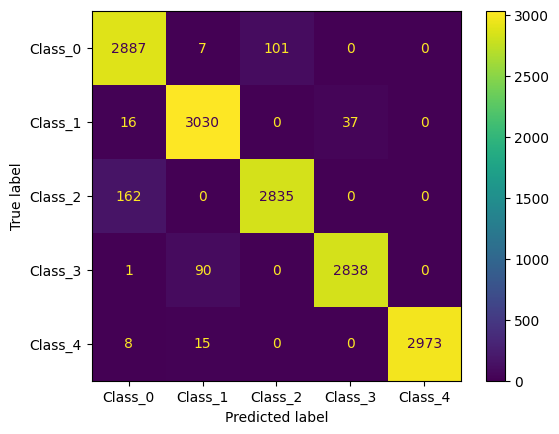

In [ ]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=ohe.get_feature_names_out())
cm_display.plot()
#  {'Arborio': 0, 'Jasmine': 1, 'Karacadag': 2, 'Basmati': 3, 'Ipsala': 4}

## Evaluate model

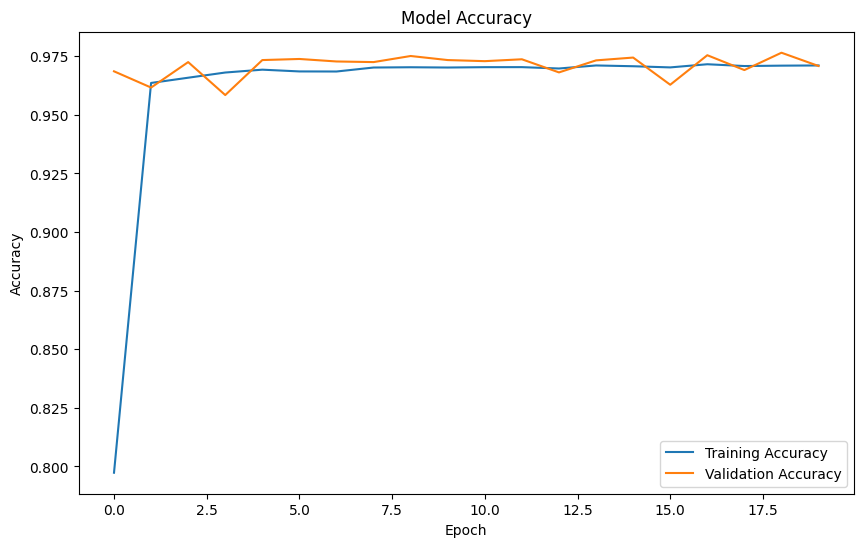

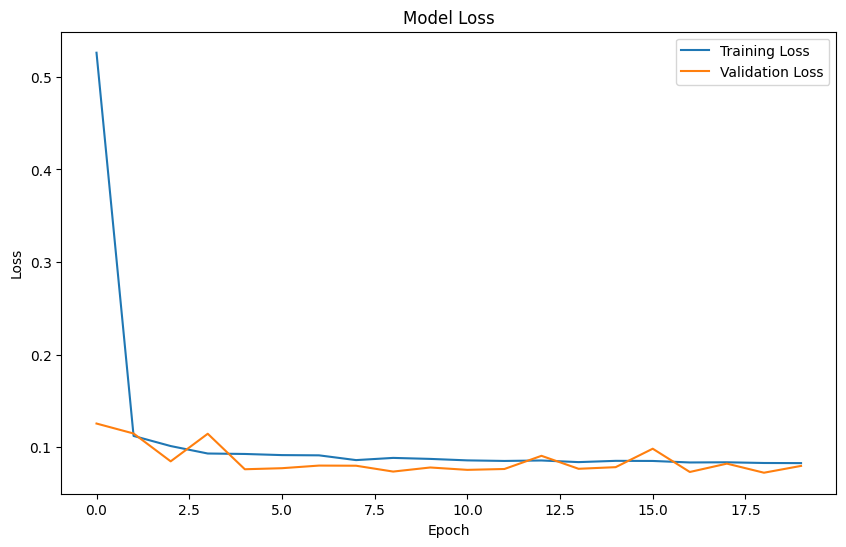

Test Accuracy: 0.9709
Test Loss: 0.0799
Class_0:
  Precision: 0.9392
  Recall: 0.9639
  F1-score: 0.9514

Class_1:
  Precision: 0.9644
  Recall: 0.9828
  F1-score: 0.9735

Class_2:
  Precision: 0.9656
  Recall: 0.9459
  F1-score: 0.9557

Class_3:
  Precision: 0.9871
  Recall: 0.9689
  F1-score: 0.9779

Class_4:
  Precision: 1.0000
  Recall: 0.9923
  F1-score: 0.9961

Overall Accuracy: 0.9709


In [ ]:
# Train the model and record history

# Plot training and validation accuracy
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Calculate precision, recall, and F1-score for each class
for i, class_name in enumerate(ohe.get_feature_names_out()):
    precision = TP[i] / (TP[i] + FP[i])
    recall = TP[i] / (TP[i] + FN[i])
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f"{class_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1_score:.4f}")
    print()

# Calculate overall accuracy
overall_accuracy = np.sum(TP) / np.sum(cm)
print(f"Overall Accuracy: {overall_accuracy:.4f}")